# Creating the data set

## Libraries, functions and classes

### Import libraries

In [1]:
import numpy as np
import pandas as pd

# Images and plots
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
from osgeo import gdal
from google.colab import files # For download images and fiels

### Functions for filter

In [2]:
def Calculate_Variance(arr):
    n = len(arr)
    if n < 2:
        return 0  # If there are less than 2 elements, variance is 0

    total = 0
    total_squared = 0
    for num in arr:
        total += num
        total_squared += num * num

    mean = total / n
    variance = (total_squared / n) - (mean * mean)

    return variance

In [3]:
def Calculate_Average(arr):
    if len(arr) < 1:  # Check if the array is empty
        return 0  # Return 0 for an empty array

    total = 0
    count = 0
    for num in arr:
        total += num
        count += 1

    average = total / count
    return average

In [4]:
import math

def Calculate_Skewness(arr):
    n = len(arr)
    if n < 3:
        return 0  # If there are less than 3 elements, skewness is 0

    total = 0
    total_cubed = 0
    for num in arr:
        total += num
        total_cubed += num * num * num

    mean = total / n
    variance = ((total_cubed / n) - (mean * mean * mean))
    std_deviation = math.sqrt(variance)

    skewness = ((total_cubed / n) - 3 * mean * (total / n) * (total / n) + 2 * mean * mean * mean) / (std_deviation * std_deviation * std_deviation)

    return skewness

### Functions

In [5]:
def Greater_Equals_One_Smaller_Equals_Zero(data, value):
    if isinstance(data, pd.DataFrame):
        result = data.copy()
        result = result.applymap(lambda x: 1 if x > value else 0)
        return result
    elif isinstance(data, np.ndarray) and data.ndim == 2:
        result = np.where(data > value, 1, 0)
        return result
    else:
        raise ValueError("Input must be a pandas DataFrame or a two-dimensional numpy array.")

In [6]:
def Image_Change_Shape(image_as_array):
  number_of_bands, height, width = image_as_array.shape
  rotated_image = np.zeros((height, width, number_of_bands))
  for i in range(number_of_bands):
    rotated_image[:, :, i] = image_as_array [i, :, :]
  return rotated_image

In [7]:
def Add_Zeros_Around_Array(arr):
    # Get the original shape of the array
    original_shape = arr.shape

    # Compute the shape of the new array with added zeros
    new_shape = (original_shape[0] + 2, original_shape[1] + 2)

    # Create a new array of zeros with the new shape
    new_array = np.zeros(new_shape)

    # Copy the original array into the center of the new array
    new_array[1:-1, 1:-1] = arr

    return new_array

In [8]:
def Split_The_Feature_To_Components(feture):
   components = feture.split("_")

   if len(components) == 4:
      band = components[0] + '_' + components[1]
      func = components[2]
      size = int(components[3])

   if len(components) == 3:
      band = components[0]
      func = components[1]
      size = int(components[2])

   return (band, func, size)

In [9]:
def Converts_The_Function_Name_To_Function(func_name):

  if func_name == 'average':
    return Calculate_Average

  elif func_name == 'variance':
    return Calculate_Variance

  elif func_name == 'skewness':
    return Calculate_Skewness

  else:
    raise ValueError("Worng function name")

### Multispectral Image

In [10]:
class Multispectral_Image:
    def __init__(self, data, band_names):
        self.data = data  # a 3D numpy array with shape (height, width, num_bands)
        self.band_names = band_names  # a 1D numpy array of strings with length num_bands
        self.shape = data.shape[:2]  # a tuple containing the image height and width

    def get_band(self, band_name):
        band_idx = np.where(self.band_names == band_name)[0]
        if len(band_idx) == 0:
            raise ValueError(f"Band {band_name} not found")
        return self.data[:, :, band_idx[0]]

    def get_pixel(self, x, y):
        return self.data[y, x, :]

    def set_pixel(self, x, y, pixel_data):
        self.data[y, x, :] = pixel_data

    def add_band(self, new_band_data, band_name):
        if new_band_data.shape != (self.shape[0], self.shape[1]):
            raise ValueError("New band data must have the same dimensions as existing image data")
        self.data = np.dstack((self.data, new_band_data))
        self.band_names = np.append(self.band_names, band_name)

    def add_band_from_1d_array(self, new_band_data, band_name):
        if new_band_data.shape[0] != self.shape[0] * self.shape[1]:
            raise ValueError("New band data must have the same number of pixels as existing image data")
        new_band_data = new_band_data.reshape((self.shape[0], self.shape[1]))
        self.add_band(new_band_data, band_name)

    def remove_band(self, band_name):
        band_idx = np.where(self.band_names == band_name)[0]
        if len(band_idx) == 0:
            raise ValueError(f"Band {band_name} not found")
        self.data = np.delete(self.data, band_idx, axis=2)
        self.band_names = np.delete(self.band_names, band_idx)

    def to_dataframe(self):
        df_data = {}
        for i in range(len(self.band_names)):
            df_data[self.band_names[i]] = self.data[:, :, i].ravel()
        return pd.DataFrame(df_data)

    def plot_band(self, band_name):
        band_idx = np.where(self.band_names == band_name)[0]
        if len(band_idx) == 0:
            raise ValueError(f"Band {band_name} not found")
        plt.imshow(self.data[:, :, band_idx[0]], cmap='gray')
        plt.title(band_name)
        plt.show()

    def plot_all_bands(self):
        fig, axs = plt.subplots(nrows=len(self.band_names), figsize=(3, 3 * len(self.band_names)))
        for i, band_name in enumerate(self.band_names):
            axs[i].imshow(self.get_band(band_name), cmap='gray')
            axs[i].set_title(band_name)
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

    def delete_rows_cols(self, x):
        if x <= 0:
            raise ValueError("Number of rows and columns to delete must be greater than zero")

        new_shape = (self.shape[0] - 2 * x, self.shape[1] - 2 * x)
        new_data = self.data[x:self.shape[0]-x, x:self.shape[1]-x, :]

        self.data = new_data
        self.shape = new_shape

### Filter

In [11]:
from sys import exit

class Filter:

  # Brief: filtering images as pandas DataFrame.
  #
  # Parameters:
  #     callback- A function that accepts 1 dimension numpy.array and returns a value for the pixel in the center of the kernel.
  #     kernel-  Square and odd numpy.array or odd integer, if integer pass the kernel will be square array of
  #              one's at the size of the integer.
  #              For example, if passed 3 the kernel would be: [[1. 1. 1.]  in default kernel = 3.
  #                                                             [1. 1. 1.]
  #                                                             [1. 1. 1.]]
  # Method:
  #   Image_Filtering(image)
  #     Parameters:
  #          image- images as pandas DataFrame.
  #
  #     Return:
  #         An filterd image as pandas DataFrame. Not that the filterd image will be
  #         smaller than the original image depending on the size of the kernel.
  #         For example if 3 * 3 kernel was passed, the filterd image will have 2 less rows and columns compared to the original image.
  #
  # Attributes:
  #     filter_image- The filtered image returned from the lest call of Image_Filtering method. Not: before first call equal False.
  #
  #
  # To do:
  #     1. Option to accept numpy.arrays and convert to pandas DataFrame.
  #     2. Option to send to Image_Filtering kernel and the default kernel will be the initialization kernel (self.kernel).
  #     3. Do not reduce image size

  ############### Initialization #######################

  def __init__(self, callback, kernel=3):
    self.callback = Filter._Initialize_Callback(callback)
    self.kernel, is_kernel_ones = Filter._Initialize_Kernel(kernel)

    self._is_kernel_ones = is_kernel_ones

    self.filter_image = False


  ########### Initialization test functions ##############

  def _Initialize_Callback(_callback):

    if callable(_callback):
      return _callback

    else:
      exit('\033[1;32m Filter class initialization problem- Filter must accept callable function.')


  ###########################

  def _Initialize_Kernel(_kernel):

    # kernel is numpy.array
    if isinstance(_kernel, np.ndarray):
      is_kernel_ones = False

      if _kernel.ndim != 2:
        exit('\033[1;32m Filter class initialization error- Filter accept only numpy.arrays with 2 dimensions as kernel.')

      vertical, horizontal = _kernel.shape

      if vertical != horizontal:
        exit('\033[1;32m Filter class initialization error- Filter does not accept a non-square array as kernel.')

      if vertical % 2 == 0:
        exit('\033[1;32m Filter class initialization error- Filter does not accept a array with even size as kernel.')

      return _kernel, is_kernel_ones


    # kernel is int (kernel of ones)
    elif isinstance(_kernel, int):
      is_kernel_ones = True

      if  _kernel < 3:
        exit('\033[1;32m Filter class initialization error- Filter does not accept integers smaller than 3 for kernel.')

      if _kernel % 2 == 0:
        exit('\033[1;32m Filter class initialization error- Filter does not accept even integers for kernel.')

      return np.ones([_kernel, _kernel]), is_kernel_ones


    # kenrel is not numpy.array or int (return error)
    else:
       exit('\033[1;32m Filter class initialization error- Filter accept only numpy.arrays and integers for kernel.')


  ###################################################

  def Image_Filtering(self, _image):

    self._Image_Check(_image)

    if self._is_kernel_ones == True:
      return self._Image_Filtering_For_Ones_Kernel(_image)

    else:
      return self._Image_Filtering_For_Non_Ones_Kernel(_image)


  ########### Helping filtering functions ###########

  def _Image_Check(self, _image):

    if not isinstance(_image, pd.core.frame.DataFrame):
        exit('\033[1;32m Image type error- Image must be pandas DataFrame.')

    kernel_size, _ = self.kernel.shape
    rows, columns = _image.shape
    if kernel_size > rows or kernel_size > columns:
       exit('\033[1;32m Size error- The image must be bigger than the kernel.')

  ###########################

  def _Image_Filtering_For_Ones_Kernel(self, _image):

    filter_image = self._Create_DataFrame_For_The_Filter_Image(_image)

    kernel_size, _ = self.kernel.shape
    filter_inage_rows, filter_image_columns = filter_image.shape

    for i in range(filter_inage_rows):
        for j in range(filter_image_columns):
          the_image_pixels = _image.iloc[i: kernel_size+i, j: kernel_size+j]
          filter_image.loc[i ,j] = self.callback(the_image_pixels.values.flatten())

    self.filter_image = filter_image
    return filter_image


  ###########################

  def _Image_Filtering_For_Non_Ones_Kernel(self, _image):

    filter_image = self._Create_DataFrame_For_The_Filter_Image(_image)

    kernel_size, _ = self.kernel.shape
    filter_inage_rows, filter_image_columns = filter_image.shape

    for i in range(filter_inage_rows):
        for j in range(filter_image_columns):
          the_image_pixels = _image.iloc[i: kernel_size+i, j: kernel_size+j]
          the_image_pixels = the_image_pixels.multiply(self.kernel, axis=0)
          filter_image.loc[i ,j] = self.callback(the_image_pixels.values.flatten())

    self.filter_image = filter_image
    return filter_image


  ###########################

  def _Create_DataFrame_For_The_Filter_Image(self, _image):

    kernel_size, _ = self.kernel.shape
    subtract_image_size = (kernel_size / 2 - 0.5) * 2 # This is because each side of the image needs to subtract half of the kernel size.
                                                      # For example if the size of the kernel is 5 on each side need to subtract 2
    rows, columns = _image.shape
    new_rows = int(rows - subtract_image_size)
    new_columns = int(columns - subtract_image_size)

    return pd.DataFrame(np.zeros((new_rows, new_columns)))

## Import the segmented image

In [38]:
image_name = '2022_gemety_zero_and_one_crop' + '.tif'
segmented_image = imread(image_name)

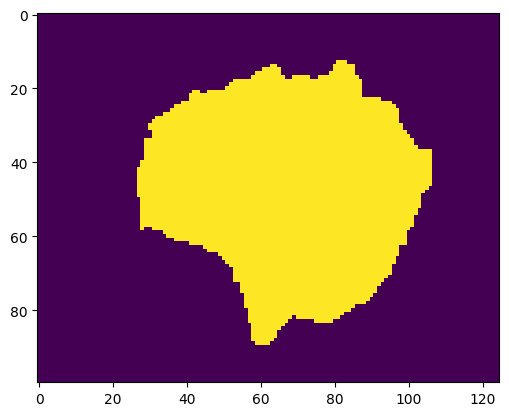

In [39]:
plt.imshow(segmented_image)

## Change for zeros and ones if needed

In [ ]:
# This may need to change
value = 100
segmented_image = Greater_Equals_One_Smaller_Equals_Zero(segmented_image, value)

In [ ]:
# save the image as tif
image_name = 'name' + '.tif'
imsave(image_name, np.uint8(segmented_image))
files.download(image_name)

# save the image as csv
file_name = 'name' + '.csv'
image_df =  pd.DataFrame(np.uint8(segmented_image))
image_df.to_csv(file_name)
files.download(file_name)

## Preparing the data (image without segmentation)

#### Import the image

In [ ]:
# Read the image
un_segmentation_image_name = '2022' + '.tif'
image_file = gdal.Open(un_segmentation_image_name)
un_segmentation_image = image_file.ReadAsArray()

In [ ]:
plt.imshow(un_segmentation_image[0, :, :], 'gray')

#### Croping if needed

In [ ]:
# crup the image if needed
# this good for geometry
row_start = 50
row_end = 150
column_start = 25
column_end = 150
un_segmentation_image = un_segmentation_image[:, row_start:row_end, column_start:column_end]

plt.imshow(un_segmentation_image[0, :, :], 'gray')

#### Only the selected features for classification

In [ ]:
# The file should contain the features you want to produce

file_name = 'Duck backward elimination with support vector classification (10 featurs selected) - prepared data' + '.csv'
selected_features = pd.read_csv(file_name)

# The file is read with a column of indexes and 'segmented' and this lines removes it
selected_features = selected_features.drop(selected_features.columns[0], axis=1)
selected_features = selected_features.drop(selected_features.columns[-1], axis=1)

In [ ]:
selected_features_list = selected_features.columns.tolist()
selected_features_list

In [ ]:
for idx, feature in enumerate(selected_features_list):

  # for the first run - creating the Multispectral_Image with the first feature
  if idx == 0:

    # get the information to create the new feature
    band, function_name, size = Split_The_Feature_To_Components(feature)
    the_function = Converts_The_Function_Name_To_Function(function_name)

    # creates the filter
    myFilter = Filter(the_function, size)

    # get the image of the band
    myImage = image.get_band(band)

    # creates the filtered image
    filter_image = myFilter.Image_Filtering(pd.DataFrame(myImage))

    # adds the size lost in the filter
    for i in range(int(size / 2 - 0.5)):
      filter_image = Add_Zeros_Around_Array(filter_image)

    # creates new Multispectral_Image with the first feature
    first_layer_name = band + '_' + function_name + '_' + str(size)
    image_of_selected_features = Multispectral_Image(filter_image, first_layer_name)


  # for all other runs - adds the new feature
  else:

    # get the information to create the new feature
    band, function_name, size = Split_The_Feature_To_Components(feature)
    the_function = Converts_The_Function_Name_To_Function(function_name)

    # creates the filter
    myFilter = Filter(the_function, size)

    # get the image of the band
    myImage = image.get_band(band)

    # creates the filtered image
    filter_image = myFilter.Image_Filtering(pd.DataFrame(myImage))

    # adds the size lost in the filter
    for i in range(int(size / 2 - 0.5)):
      filter_image = Add_Zeros_Around_Array(filter_image)

    # add the new layer
    new_layer_name = band + '_' + function_name + '_' + str(size)
    image_of_selected_features.add_band(filter_image, new_layer_name)

In [ ]:
image_of_selected_features.plot_all_bands()

#### All filters

In [26]:
# This lines in case new data is generated (all filters are run)
bands = np.array(['blue', 'green', 'red', 'NIR', 'SWIR_1', 'SWIR_2'])
image = Multispectral_Image(Image_Change_Shape(un_segmentation_image), bands)

##### Mean filter

###### 3 x 3

In [27]:
size = 3
mean_filter = Filter(Calculate_Average, size)
name_add = '_average_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 5 x 5

In [28]:
size = 5
mean_filter = Filter(Calculate_Average, size)
name_add = '_average_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 7 x 7

In [29]:
size = 7
mean_filter = Filter(Calculate_Average, size)
name_add = '_average_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

##### Variance filter

###### 3 x 3

In [30]:
size = 3
mean_filter = Filter(Calculate_Variance, size)
name_add = '_variance_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 5 x 5

In [31]:
size = 5
mean_filter = Filter(Calculate_Variance, size)
name_add = '_variance_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 7 x 7

In [32]:
size = 7
mean_filter = Filter(Calculate_Variance, size)
name_add = '_variance_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

##### Skewness filter

###### 3 x 3

In [33]:
size = 3
mean_filter = Filter(Calculate_Skewness, size)
name_add = '_skewness_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 5 x 5

In [34]:
size = 5
mean_filter = Filter(Calculate_Skewness, size)
name_add = '_skewness_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

###### 7 x 7

In [35]:
size = 7
mean_filter = Filter(Calculate_Skewness, size)
name_add = '_skewness_' + str(size)

for band in bands:
  myImage = image.get_band(band)
  filter_image = mean_filter.Image_Filtering(pd.DataFrame(myImage))

  # adds the size lost in the filter
  for i in range(int(size / 2 - 0.5)):
    filter_image = Add_Zeros_Around_Array(filter_image)

  new_band_name = band + name_add
  image.add_band(filter_image, new_band_name)

## Added the image with segmentation

In [36]:
# NOTE:
# If new data is produced (all filters) the Multispectral_Image object name will be "image"
# If only certain features have been created the Multispectral_Image object name will be "image_of_selected_features"

In [42]:
# Adds the segmentation
image.add_band(segmented_image, 'segmented')

# Cuts the surrounding - zeros added after the filter
image.delete_rows_cols(3)

In [ ]:
image.plot_all_bands()

In [ ]:
len(image.band_names)

In [ ]:
image.shape

## Flatten and save as csv

In [49]:
myData = image.to_dataframe()

In [50]:
file_name = 'Geometry (all featurs selected) - prepared data' + '.csv'
myData.to_csv(file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>